In [2]:
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import psycopg2
import numpy as np
from psycopg2.extras import execute_values
from faiss import read_index
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar modelo e indice

In [3]:
model = Doc2Vec.load("python.doc")
index = read_index("python.index")

# Traer nuevas preguntas

In [4]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="63333",
    database="stack_overflow",
)

In [5]:
MIN_ANSWERS = 9
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 3000"""
        )
        posts = cursor.fetchall()

# Encontrar las preguntas cercanas y sus vectores de distancia

In [6]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(model.infer_vector(simple_preprocess(post_text)))

In [7]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(1371, 50)

## Cantidad de vectores en relacion al radio

In [8]:
def get_found_vectors_dist(limits):
    k_vects = np.array([limits[i + 1] - limits[i] for i in range(len(limits) - 1)])
    return k_vects.mean(), k_vects.std()

In [9]:
test_radius = [10, 20, 30, 40, 50]
k_vects_dist = []
for radius in test_radius:
    limits, distances, similar_questions = index.range_search(posts_vectors, radius)
    k_vects_dist.append(get_found_vectors_dist(limits))
k_vects_dist = np.array(k_vects_dist)

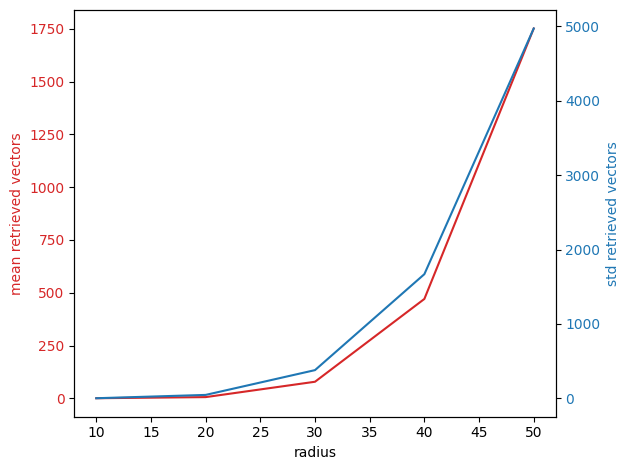

In [10]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("radius")
ax1.set_ylabel("mean retrieved vectors", color=color)
ax1.plot(test_radius, k_vects_dist[:, 0], color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("std retrieved vectors", color=color)
ax2.plot(test_radius, k_vects_dist[:, 1], color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()

## Distancia de los vectores en funcion de K

In [45]:
def get_vector_distance_dist(posts_vectors, similar_questions):
    exact_distances = []
    for p_vector, similar_qs in zip(posts_vectors, similar_questions):
        for s_q in similar_qs:
            sq_vector = model.dv[str(s_q)]
            exact_distances.append(np.linalg.norm(p_vector - sq_vector))
    exact_distances = np.array(exact_distances)
    return exact_distances.mean(), exact_distances.std()

In [46]:
test_k = [50, 100, 500, 1000, 5000, 10000, 30000, 50000]
distance_dist = []
for k in test_k:
    distances, similar_questions = index.search(posts_vectors, k)
    distance_dist.append(get_vector_distance_dist(posts_vectors, similar_questions))
distance_dist = np.array(distance_dist)

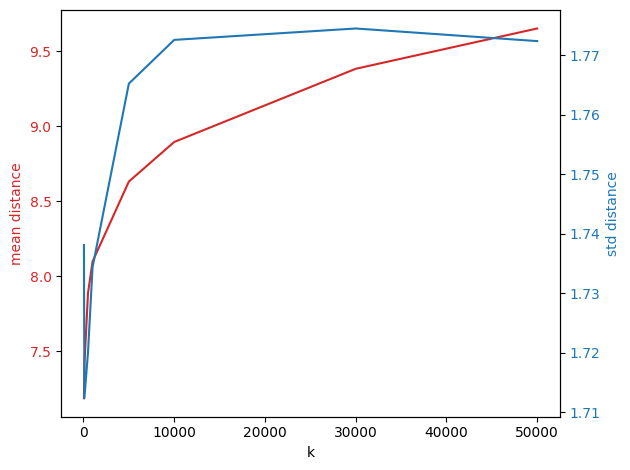

In [47]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean distance", color=color)
ax1.plot(test_k, distance_dist[:, 0], color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("std distance", color=color)
ax2.plot(test_k, distance_dist[:, 1], color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()

In [48]:
distance_dist

array([[7.1868024, 1.7381445],
       [7.4115095, 1.7123921],
       [7.8890243, 1.7201931],
       [8.097808 , 1.7344241],
       [8.630973 , 1.7652571],
       [8.894785 , 1.7726033],
       [9.382531 , 1.7745184],
       [9.651164 , 1.7723982]], dtype=float32)

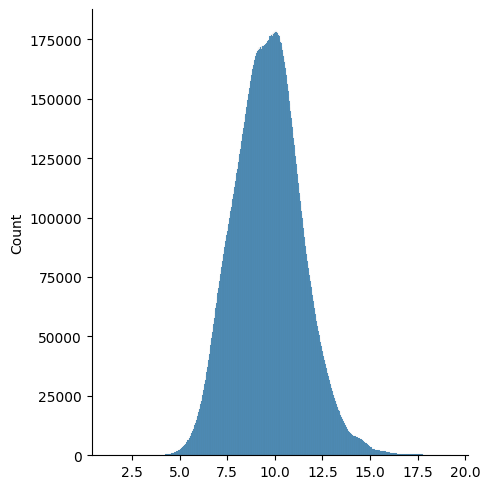

In [49]:
exact_distances = []
for p_vector, similar_qs in zip(posts_vectors, similar_questions):
    for idx, s_q in enumerate(similar_qs):
        sq_vector = model.dv[str(s_q)]
        exact_distances.append(np.linalg.norm(p_vector - sq_vector))
sns.displot(exact_distances)

### Recall vs k

In [50]:
distances, similar_questions = index.search(posts_vectors[:3], 50000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "sq_id"]
).explode("sq_id")
features_df["sq_id"] = features_df["sq_id"].astype(int)

In [51]:
def get_recall_dist(features_df):
    with connection:
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, sq_id, q_a.owner_user_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, sq_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    JOIN posts_19 sq ON sq.id = sq_id
                                    JOIN posts_19 sq_a ON sq_a.id = sq.accepted_answer_id
                                    WHERE sq_a.owner_user_id=q_a.owner_user_id""",
                features_df[["q_id", "sq_id"]].values.tolist(),
                page_size=len(features_df),
            )
            q_ds = cursor.fetchall()
            q_ds = pd.DataFrame(q_ds, columns=["q_id", "sq_id", "user_id", "score"])

        with connection.cursor() as cursor:
            cursor.execute(
                """select a.parent_id, count(*)
                                FROM posts_19 a
                                WHERE a.parent_id in %s
                                GROUP BY a.parent_id""",
                (tuple(q_ds["q_id"].unique().tolist()),),
            )
            ans_ds = cursor.fetchall()
            ans_ds = pd.DataFrame(ans_ds, columns=["q_id", "answers"])
    recall_df = (
        q_ds.drop_duplicates(["q_id", "user_id"])
        .groupby("q_id")
        .count()
        .merge(ans_ds, on="q_id")
    )
    recall_df["recall"] = recall_df["sq_id"] / recall_df["answers"]
    return recall_df["recall"].mean(), recall_df["recall"].std()

In [52]:
get_recall_dist(features_df)

(0.32550782550782553, 0.12111659755663441)

In [62]:
test_k = [50, 100, 500, 1000, 5000, 10000, 30000, 50000]
recall_dist = []
for k in test_k:
    distances, similar_questions = index.search(posts_vectors[:50], k)
    features_df = pd.DataFrame(
        list(zip(posts_ids, similar_questions)), columns=["q_id", "sq_id"]
    ).explode("sq_id")
    features_df["sq_id"] = features_df["sq_id"].astype(int)
    recall_dist.append(get_recall_dist(features_df))
recall_dist = np.array(recall_dist)

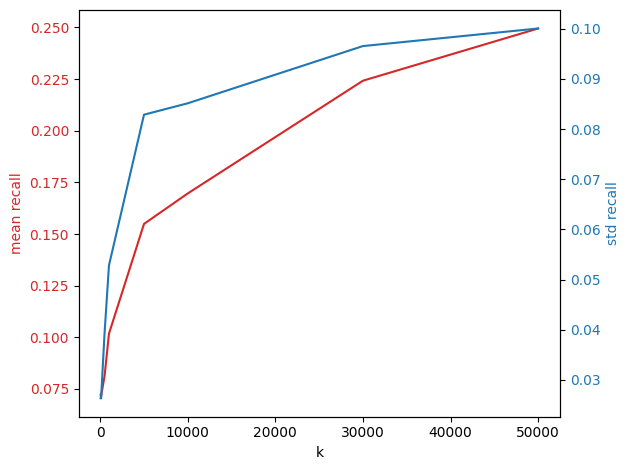

In [63]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall", color=color)
ax1.plot(test_k, recall_dist[:, 0], color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("std recall", color=color)
ax2.plot(test_k, recall_dist[:, 1], color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()